Game Description:
https://yunhai.ctrip.com/Games/9

In [2]:
# initial environment
import pandas as pd
import numpy as np
import numpy.random as nr

nr.seed(42)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [3]:
product_info = pd.read_csv("product_data/product_info.txt")
product_quantity = pd.read_csv("product_data/product_quantity.txt")

In [4]:
product_info.shape
product_info.columns

Index([u'product_id', u'district_id1', u'district_id2', u'district_id3',
       u'district_id4', u'lat', u'lon', u'railway', u'airport', u'citycenter',
       u'railway2', u'airport2', u'citycenter2', u'eval', u'eval2', u'eval3',
       u'eval4', u'voters', u'startdate', u'upgradedate', u'cooperatedate',
       u'maxstock'],
      dtype='object')

In [4]:
product_quantity.shape

(1959676, 9)

In [5]:
product_info.head()

,product_id,district_id1,district_id2,district_id3,district_id4,lat,lon,railway,airport,citycenter,...,citycenter2,eval,eval2,eval3,eval4,voters,startdate,upgradedate,cooperatedate,maxstock
0,1,10201,20502,31003,45760,3.994928,11.634630,-1.0,-1.0,-1.0,...,-1.0,3.0,5,2.0,3.1,1034.0,2005-11-01,2015-01-01,2013-07-02,75.0
1,2,10201,20502,31003,45760,3.995148,11.636258,-1.0,-1.0,2.3,...,-1.0,3.0,4,2.0,3.4,1707.0,2005-02-28,2011-01-01,2014-12-16,172.0
2,3,10201,20502,31003,45760,3.994291,11.631246,-1.0,-1.0,10.3,...,-1.0,3.0,4,2.5,3.6,1739.0,2007-03-01,2014-01-01,2014-07-02,188.0
3,4,10201,20502,31003,55952,3.997783,11.641561,-1.0,-1.0,9.3,...,-1.0,3.0,4,2.5,3.5,1065.0,2006-07-01,1753-01-01,2014-12-19,116.0
4,5,10201,20502,31003,55952,3.999904,11.641149,12.1,25.2,13.3,...,3.6,3.0,5,2.0,3.4,2209.0,2007-01-01,2012-03-01,2007-11-07,95.0


In [6]:
product_quantity.head()

,product_id,product_date,orderattribute1,orderattribute2,orderattribute3,orderattribute4,ciiquantity,ordquantity,price
0,1,2014-06-21,2,1,1,1,0,1,-1
1,1,2014-09-03,2,1,1,1,1,3,153
2,1,2014-09-26,2,1,1,1,0,3,-1
3,1,2014-11-28,2,1,1,1,0,4,-1
4,1,2014-01-11,2,1,1,1,1,1,153


In [10]:
1959676/30/4000

16

#### 0. 数据第一印象

4000个产品，1959676天的交易记录，每个产品大概有16个月每天每单的交易记录
1. 每个产品有22个属性, 21个有效属性。分为地理因素、评分、时间、库存4类。
2. 订单拥有9个属性，8个有用属性，分为时间、订单信息、预定数和实际交易数和价格。
【疑惑：每个物品销售时价格和属性是变化的, 订单是用户的行为特征，包括价格接受范围情况】

> 升级时间是指产品的质量或服务得到了大幅度提升的时间点；订单属性是订单的各种特性或类别，例如人的性别、高矮胖瘦等.

#### 1. Look at the big picture从系统角度分析
1. 当前模块在实际系统中的位置，和其他部门进行沟通协作
2. 已有的成熟解决方案，可参考的准确率，业界在特征方面的考虑
3. 从数学和机器学习角度描述问题
4. 挑选一个性能优化指标

分析：
1. 通过预计每个月的销量，来指导产品的库存管理和定价策略。【**??问题：价格本身就是销量影响因素？？每个产品不同月份的价格本身就不同**】
2. 已有方案：用每个产品的历史增长幅度和历史销量回归一下，【特征：在出行产品预订业务中，**不同区域**的产品需求量级不一样，**不同时段**需求量会有高低起伏，相同区域相同时段各产品的需求量因**产品特性**不同又有差异。】个人觉得：挖掘订单中用户特征比较重要，对价格的容忍度，以及用户本身具有一些特征
3. 离线回归问题 + 预测。
4. 优化指标：如果数据存在outlier而且无法挑选出，建议用MAE，否则通常使用RMSE

#### 2. Get the data数据分析
1. 数学表示：连续还是离散，是否人工修剪过，范围,是否分布均匀

In [15]:
product_info.head()

,product_id,district_id1,district_id2,district_id3,district_id4,lat,lon,railway,airport,citycenter,...,citycenter2,eval,eval2,eval3,eval4,voters,startdate,upgradedate,cooperatedate,maxstock
0,1,10201,20502,31003,45760,3.994928,11.634630,-1.0,-1.0,-1.0,...,-1.0,3.0,5,2.0,3.1,1034.0,2005-11-01,2015-01-01,2013-07-02,75.0
1,2,10201,20502,31003,45760,3.995148,11.636258,-1.0,-1.0,2.3,...,-1.0,3.0,4,2.0,3.4,1707.0,2005-02-28,2011-01-01,2014-12-16,172.0
2,3,10201,20502,31003,45760,3.994291,11.631246,-1.0,-1.0,10.3,...,-1.0,3.0,4,2.5,3.6,1739.0,2007-03-01,2014-01-01,2014-07-02,188.0
3,4,10201,20502,31003,55952,3.997783,11.641561,-1.0,-1.0,9.3,...,-1.0,3.0,4,2.5,3.5,1065.0,2006-07-01,1753-01-01,2014-12-19,116.0
4,5,10201,20502,31003,55952,3.999904,11.641149,12.1,25.2,13.3,...,3.6,3.0,5,2.0,3.4,2209.0,2007-01-01,2012-03-01,2007-11-07,95.0


In [61]:
product_info['district_id1'].value_counts()

10201    3904
10504      28
17978      19
10403      17
10302       5
16766       5
24846       5
14342       3
21109       2
11615       2
21008       2
21311       1
13231       1
18180       1
11514       1
13332       1
12928       1
14847       1
20806       1
Name: district_id1, dtype: int64

In [62]:
product_info['district_id2'].value_counts()

 22746      536
 21420      291
 22644      278
 22338      263
 20502      245
 21930      215
 21318      183
 20604      181
 22032      180
 22440      131
 20808      129
 22542      116
 22950      109
 22848      107
 20706      103
 23562       86
 21114       77
 21216       74
 21624       74
 22134       66
 21726       66
 22236       59
 21522       57
 23358       52
 20400       48
 21012       47
 23052       42
 23256       35
 20910       33
 23154       24
           ... 
 23460        7
 21828        7
-1            5
 1053558      3
 1148418      3
 1049784      2
 1145664      2
 1071102      2
 27132        2
 1153722      2
 1151376      1
 1057128      1
 1049274      1
 1151274      1
 1053150      1
 23766        1
 1068858      1
 1307640      1
 1148010      1
 1160352      1
 1062636      1
 1193808      1
 1048254      1
 1059066      1
 1157394      1
 1051314      1
 1055598      1
 1076202      1
 1055802      1
 1187790      1
Name: district_id2, dtyp

In [63]:
product_info['district_id3'].value_counts()

34196      259
31003      245
31106      181
31621      173
33475      167
31312      129
33990      115
33784      114
31209      103
88477       81
69010       79
35329       66
32136       60
80031       54
32651       52
52118       52
32342       49
31930       47
34608       43
64993       42
56753       40
31518       36
86726       35
47174       32
33681       32
41715       30
70040       30
34402       29
83945       28
59534       27
          ... 
826369       1
191477       1
40376        1
2292677      1
142243       1
105369       1
67053        1
2229126      1
2296076      1
134312       1
56238        1
79104        1
1089019      1
50676        1
66229        1
236488       1
431055       1
95275        1
126381       1
363590       1
683405       1
2248284      1
66641        1
363899       1
427141       1
2256215      1
1088813      1
83224        1
46350        1
2293707      1
Name: district_id3, dtype: int64

In [64]:
product_info['district_id4'].value_counts()

-1          750
 1277016    103
 54080       89
 50544       88
 45760       78
 460200      77
 48256       66
 154752      65
 114400      61
 55952       58
 58656       51
 52000       48
 70512       47
 154232      37
 146640      36
 47320       35
 121784      34
 80184       34
 116272      32
 43576       32
 80288       31
 1321320     30
 145808      28
 1431872     27
 156208      27
 121472      27
 120224      27
 162240      26
 144040      25
 138736      25
           ... 
 144872       1
 105664       1
 87256        1
 138528       1
 1451632      1
 1469208      1
 121056       1
 1340664      1
 1186640      1
 1278576      1
 1468584      1
 107744       1
 1395576      1
 1389232      1
 477464       1
 474136       1
 1405768      1
 1458912      1
 136344       1
 1180400      1
 1403272      1
 1458288      1
 137592       1
 1410552      1
 1389336      1
 1563224      1
 156312       1
 1289288      1
 1436240      1
 1282216      1
Name: district_id4, dtyp

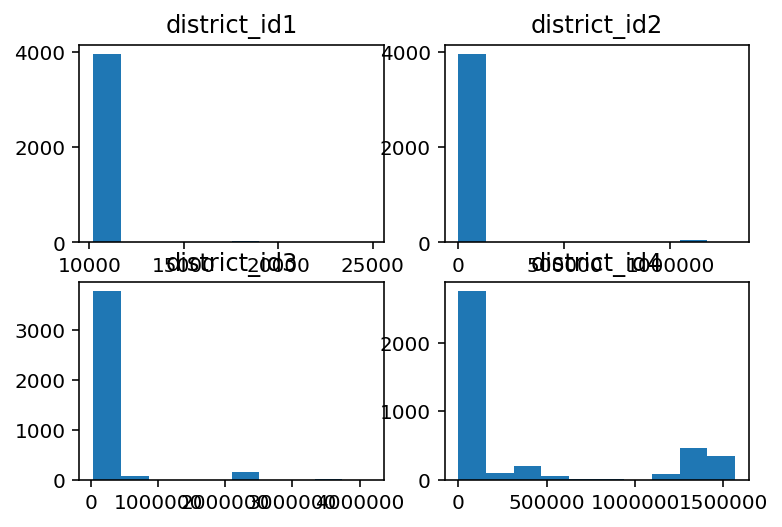

In [6]:
district_id1 = product_info['district_id1']
district_id2 = product_info['district_id2']
district_id3 = product_info['district_id3']
district_id4 = product_info['district_id4']
plt.subplot(2, 2, 1)
plt.title("district_id1")
plt.hist(district_id1)
plt.subplot(2, 2, 2)
plt.title("district_id2")
plt.hist(district_id2)
plt.subplot(2, 2, 3)
plt.title("district_id3")
plt.hist(district_id3)
plt.subplot(2, 2, 4)
plt.title("district_id4")
plt.hist(district_id4)
plt.show()

In [67]:
product_info.head()

,product_id,district_id1,district_id2,district_id3,district_id4,lat,lon,railway,airport,citycenter,...,citycenter2,eval,eval2,eval3,eval4,voters,startdate,upgradedate,cooperatedate,maxstock
0,1,10201,20502,31003,45760,3.994928,11.634630,-1.0,-1.0,-1.0,...,-1.0,3.0,5,2.0,3.1,1034.0,2005-11-01,2015-01-01,2013-07-02,75.0
1,2,10201,20502,31003,45760,3.995148,11.636258,-1.0,-1.0,2.3,...,-1.0,3.0,4,2.0,3.4,1707.0,2005-02-28,2011-01-01,2014-12-16,172.0
2,3,10201,20502,31003,45760,3.994291,11.631246,-1.0,-1.0,10.3,...,-1.0,3.0,4,2.5,3.6,1739.0,2007-03-01,2014-01-01,2014-07-02,188.0
3,4,10201,20502,31003,55952,3.997783,11.641561,-1.0,-1.0,9.3,...,-1.0,3.0,4,2.5,3.5,1065.0,2006-07-01,1753-01-01,2014-12-19,116.0
4,5,10201,20502,31003,55952,3.999904,11.641149,12.1,25.2,13.3,...,3.6,3.0,5,2.0,3.4,2209.0,2007-01-01,2012-03-01,2007-11-07,95.0


In [68]:
product_info.columns

Index([u'product_id', u'district_id1', u'district_id2', u'district_id3',
       u'district_id4', u'lat', u'lon', u'railway', u'airport', u'citycenter',
       u'railway2', u'airport2', u'citycenter2', u'eval', u'eval2', u'eval3',
       u'eval4', u'voters', u'startdate', u'upgradedate', u'cooperatedate',
       u'maxstock'],
      dtype='object')

In [74]:
product_info.railway.value_counts()
product_info.airport2.value_counts()

-1.0     3878
 3.5       19
 1.5       19
 2.5       15
 1.0       14
 2.0       11
 4.5        5
 7.5        4
 5.5        3
 3.0        3
 6.5        3
 5.0        2
 10.5       2
 4.2        2
 0.7        2
 0.8        2
 0.6        2
 4.0        2
 13.5       1
 2.1        1
 8.5        1
 3.9        1
 12.5       1
 3.2        1
 3.3        1
 3.8        1
 1.8        1
 25.5       1
 2.7        1
 1.1        1
Name: airport2, dtype: int64

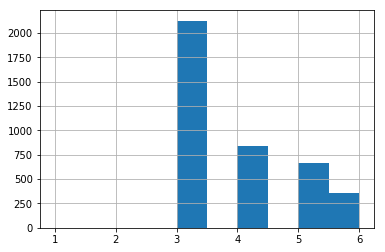

In [78]:
product_info['eval'].hist()

In [80]:
product_quantity.head()

,product_id,product_date,orderattribute1,orderattribute2,orderattribute3,orderattribute4,ciiquantity,ordquantity,price
0,1,2014-06-21,2,1,1,1,0,1,-1
1,1,2014-09-03,2,1,1,1,1,3,153
2,1,2014-09-26,2,1,1,1,0,3,-1
3,1,2014-11-28,2,1,1,1,0,4,-1
4,1,2014-01-11,2,1,1,1,1,1,153


In [101]:
product_quantity.loc[0]

product_id                  1
product_date       2014-06-21
orderattribute1             2
orderattribute2             1
orderattribute3             1
orderattribute4             1
ciiquantity                 0
ordquantity                 1
price                      -1
Name: 0, dtype: object

In [108]:
product_quantity.index

RangeIndex(start=0, stop=1959676, step=1)

#### 实现base模型
计算每个产品每个月的销量，直接作为预估值

In [3]:
def product_month_count(data):
    '''统计每个产品12个月份的销量情况'''
    from collections import defaultdict
    month_count = defaultdict(dict)
    m, n = data.shape
    
    for idx in product_quantity.index:
        if idx % 10000 == 0:
            print idx
        row = data.loc[idx]
        product_id = row['product_id']
        product_month = int(row['product_date'].split('-')[1])
        quantity = row['ciiquantity']
        month_count[product_id].setdefault(product_month, 0)
        month_count[product_id][product_month] += quantity
    
    return month_count

In [4]:
def print_result(product_month_count):
    month_list = range(0, 14, 1)    #  总共14个月
    for product_id, count in product_month_count.iteritems():
        average_month = 0
        average_month = sum(count.itervalues()) / len(count)
        for month in month_list:
            if month == 0:
                month_info = "2015-12-01"
            elif month == 13:
                month_info = "2017-01-01"
            else:
                month_info = "2016-%02d-01" % month
            
            if month not in count:
                value = average_month
            else:
                value = count[month]
            
            print "{0},{1},{2}".format(product_id, month_info, value)
            

In [5]:
month_count = product_month_count(product_quantity)
print_result(month_count)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000
500000
510000
520000
530000
540000
550000
560000
570000
580000
590000
600000
610000
620000
630000
640000
650000
660000
670000
680000
690000
700000
710000
720000
730000
740000
750000
760000
770000
780000
790000
800000
810000
820000
830000
840000
850000
860000
870000
880000
890000
900000
910000
920000
930000
940000
950000
960000
970000
980000
990000
1000000
1010000
1020000
1030000
1040000
1050000
1060000
1070000
1080000
1090000
1100000
1110000
1120000
1130000
1140000
1150000
1160000
1170000
1180000
1190000
1200000
1210000
1220000
1230000
1240000
1250000
1260000
1270000
1280000
1290000
1300000
1310000
1320000
1330000
1340000
1350000
1360000
1370000
1380000
13

#### 第一次提交结果为256

#### 3. 可视化：
- 可视化lat和lng，
- 可视化销量和月份以及各种数据的关系

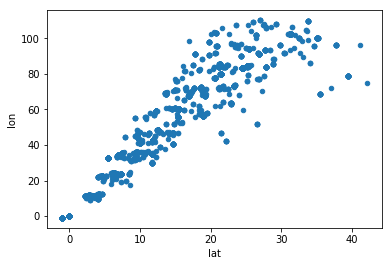

In [131]:
product_info.plot(kind='scatter', x='lat', y='lon')

**整理数据**
1. 所有产品的月销量矩阵
2. 所有产品的属性数据，包括离散和连续数据【地理位置这些不好处理】

In [7]:
m = len(month_count)
n = 12
sale_matrix = np.zeros((m, n))
num_product_name = []
idx = 0
for product_id, values in month_count.iteritems():
    num_product_name.append(product_id)
    
    for month, value in values.iteritems():
        sale_matrix[idx, month-1] = value
    
    idx += 1

In [60]:
from pandas import DataFrame
sale_data = DataFrame(sale_matrix, columns=range(1, 13))
Y = sale_matrix

In [150]:
product_info.columns

Index([u'product_id', u'district_id1', u'district_id2', u'district_id3',
       u'district_id4', u'lat', u'lon', u'railway', u'airport', u'citycenter',
       u'railway2', u'airport2', u'citycenter2', u'eval', u'eval2', u'eval3',
       u'eval4', u'voters', u'startdate', u'upgradedate', u'cooperatedate',
       u'maxstock'],
      dtype='object')

In [12]:
attr_list = [u'railway', u'airport', u'citycenter',
       u'railway2', u'airport2', u'citycenter2', u'eval', u'eval2', u'eval3',
       u'eval4', u'voters', u'maxstock']
useful_info = product_info[attr_list]

In [152]:
useful_info.shape

(4000, 12)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11369b410>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x113bdc950>]], dtype=object)

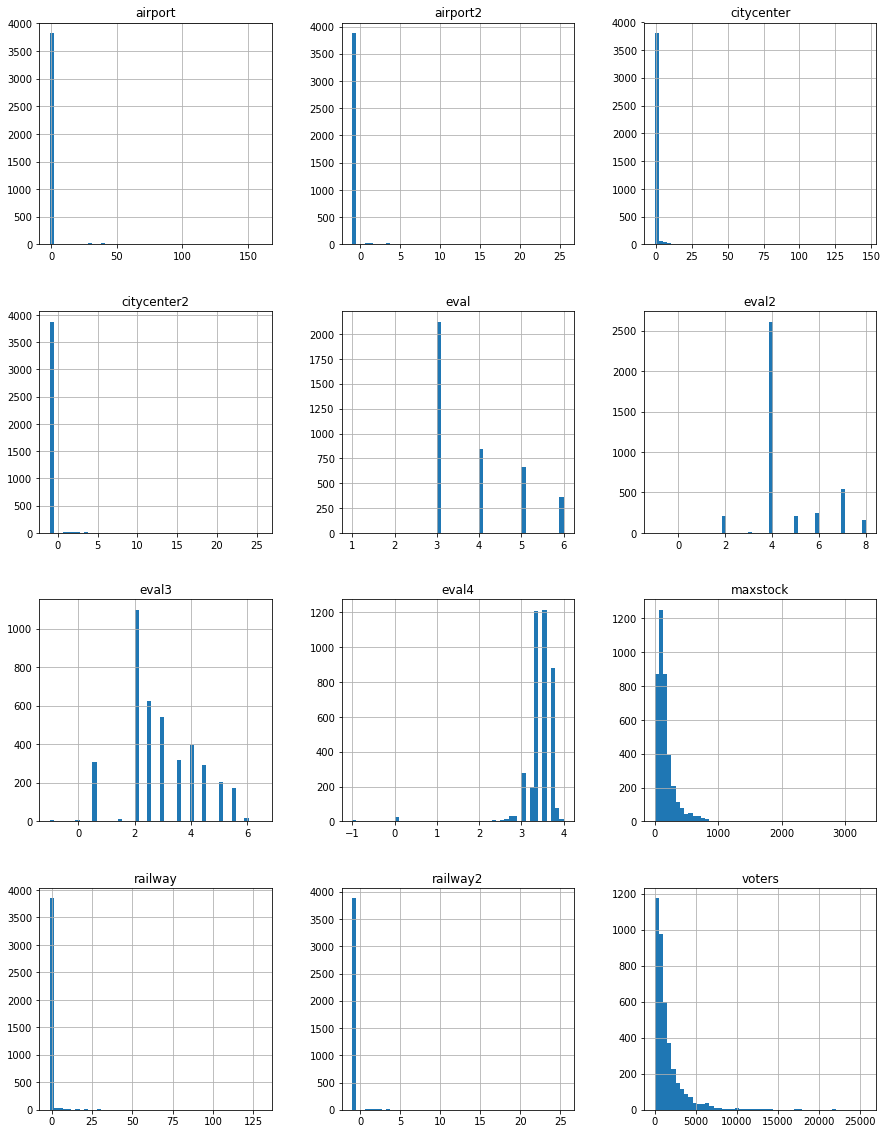

In [154]:
useful_info.hist(bins=50, figsize=(15, 20))

In [ ]:
#### 需要去除NA以及Standard

In [44]:
def fillempty(data, default=-1.0):
    """使用平均值填充所有值为default的数据"""
    m, n = data.shape
    for col in xrange(n):
        temp = (data[:, col] != default)
        xx = data[temp, col]
        mean_value = np.mean(xx)
        cnt = 0
        for row in xrange(m):
            if data[row, col] == default:
                cnt += 1
                data[row, col] = mean_value
        print cnt
    return data

def get_valid_rows(data, valid_product_list):
    rows = []
    for index, product_id in enumerate(data):
        if product_id in valid_product_list:
            rows.append(index)
    
    return rows

data = fillempty(useful_info.values)
new_data = DataFrame(data, columns=attr_list)
rows = get_valid_rows(product_info.product_id.values, num_product_name)
final_product_info = data[rows, :]

3823
3822
3736
3878
3878
3878
0
5
5
8
8
5


In [45]:
from sklearn.preprocessing import StandardScaler
standard_data = StandardScaler().fit_transform(final_product_info)

In [46]:
sta_df = DataFrame(standard_data, columns=attr_list)

In [47]:
X = sta_df.values

In [48]:
X.shape, Y.shape

((3495, 12), (3495, 12))

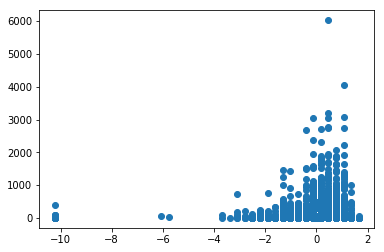

In [63]:
plt.scatter(X[:, 9], Y[:, 0])

In [66]:
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LinearRegression


lr = LinearRegression()
lr.fit(X, Y[:, 0])

array([ 0.34606749,  0.20433321, -1.83802404])